### IMPORTING NECESSARY LIBRARIES

In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential , Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils.all_utils import plot_model
from keras.preprocessing import image

### GETTING DATASET

In [ ]:
!wget https://www.dropbox.com/s/6ih3a5z2dj4ibln/simpsons_faces.zip?dl=0

In [ ]:
!unzip simpsons_faces.zip?dl=0

In [4]:
!ls

 archive   sample_data	'simpsons_faces.zip?dl=0'


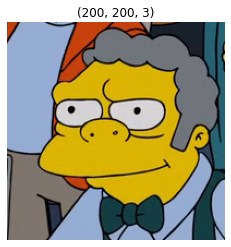

In [24]:
## Visualizing sample Image

sample = plt.imread('/content/archive/cropped/100.png')
plt.imshow(sample)
plt.axis('off')
plt.title(sample.shape)
plt.show()

In [25]:
## Total image samples

print(len(os.listdir('/content/archive/cropped')))

9790


### DATA PREPARATION AND NORMALIZATION

In [26]:
X_train = []

for im in os.listdir('/content/archive/cropped'):
    img = image.load_img(os.path.join('/content/archive/cropped' , im) , target_size=(128,128))
    
    # Normalize data in range (-1 , 1)
    img = image.img_to_array(img)/255.0
    img = (img-0.5)/0.5 
    X_train.append(img)

In [27]:
X_train = np.array(X_train)
print(X_train.shape)

(9790, 128, 128, 3)


In [28]:
np.max(X_train) , np.min(X_train)

(1.0, -1.0)

### VISUALIZATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


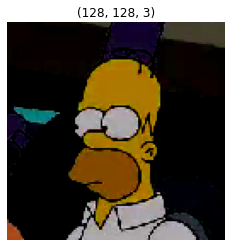

In [29]:
plt.imshow(X_train[10])
plt.axis('off')
plt.title(X_train[0].shape)
plt.show()

In [30]:
## Hyperparameters

NOISE_DIM = 100        # input noise vector
TOTAL_EPOCHS = 300
BATCH_SIZE = 64
NO_OF_BATCHES = len(X_train)//BATCH_SIZE     # No of batch iterations in one epoch
HALF_BATCH = BATCH_SIZE//2                   # half fake and half real data to pass through discriminator

adam = Adam(learning_rate=2e-4 , beta_1=0.5)

print(HALF_BATCH , NO_OF_BATCHES)

32 152


### GENERATOR MODEL

In [33]:
generator = Sequential()

generator.add(Dense(8*8*1024 , input_shape = (NOISE_DIM,)))
generator.add(Reshape((8, 8, 1024)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(512, (5,5), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())


generator.add(Conv2DTranspose(256, (5,5), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())


generator.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(3, (5,5), strides=(1,1), padding='same' , activation='tanh'))

generator.compile(loss = 'binary_crossentropy' , optimizer = adam)
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 16, 16, 512)       13107712  
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 512)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 512)      

In [ ]:
plot_model(generator , to_file = 'generator.png' , show_shapes=True)

### DISCRIMINATOR MODEL

In [35]:
discriminator = Sequential()

discriminator.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape = (128, 128, 3)))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1 , activation = 'sigmoid'))

discriminator.compile(loss = 'binary_crossentropy' , optimizer = adam)
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 512)        

In [ ]:
plot_model(discriminator , to_file = 'discriminator.png' , show_shapes=True)

### COMBINING BOTH NEURAL NETWORKS FOR GENERATOR TRAINING (consider discriminator frozen)

In [37]:
discriminator.trainable = False
gan_input = Input(shape= (NOISE_DIM))
gen_img = generator(gan_input)
gan_output = discriminator(gen_img)

model = Model(gan_input , gan_output)
model.compile(loss = 'binary_crossentropy' , optimizer = adam)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 128, 128, 3)       24040835  
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 4339329   
Total params: 28,380,164
Trainable params: 24,036,867
Non-trainable params: 4,343,297
_________________________________________________________________


In [38]:
## Function to display generated images

def save_imgs(epoch):
    noise = np.random.normal(0 , 1 , size = (BATCH_SIZE , NOISE_DIM))
    generated_imgs = generator.predict(noise).reshape(-1, 128, 128, 3)
    plt.figure(figsize = (12 , 12))
    
    for i in range(BATCH_SIZE):
        plt.subplot(8 , 8 , i+1)
        plt.imshow(generated_imgs[i] , interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
!mkdir images

In [ ]:
d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):
    d_epoch_loss = 0.0
    g_epoch_loss = 0.0

    # Mini Batch SGD
    for step in range(NO_OF_BATCHES): 
        
        # STEP - 1 : Training Discriminator considering Generator frozen
        
        # Fake Data X - generate 50% random images
        noise = np.random.normal(0 , 1 , size = (HALF_BATCH , NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        # Real Data X - randomly select 50% real images
        ids = np.random.randint(0 , len(X_train) , HALF_BATCH)
        real_imgs = X_train[ids]
        
        # Labels
        fake_y = np.zeros((HALF_BATCH , 1))
        real_y = np.ones((HALF_BATCH , 1))*0.9  # One Sided Label Smoothing for Discriminator
        
        # Train discriminator on both batches of data separately and combine the loss
        d_loss_real = discriminator.train_on_batch(real_imgs , real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs , fake_y)

        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        d_epoch_loss += d_loss
        
        
        # STEP - 2 : Train Generator (Complete Model Generator + Frozen Discriminator)
        noise = np.random.normal(0 , 1 , size = (BATCH_SIZE , NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE , 1))

        g_loss = model.train_on_batch(noise , ground_truth_y)
        g_epoch_loss += g_loss
        
    # Avg loss per batch
    g_losses.append(g_epoch_loss/NO_OF_BATCHES)
    d_losses.append(d_epoch_loss/NO_OF_BATCHES)

    print('Epoch %d , Discriminator Loss %.4f , Generator Loss %.4f'%(epoch+1 , g_epoch_loss/NO_OF_BATCHES , d_epoch_loss/NO_OF_BATCHES))
  
    if (epoch+1)%30 == 0:
        save_imgs(epoch+1)
        plt.savefig('images/gan_output_epoch_{}.png'.format(epoch+1))
        

In [ ]:
!zip -r /content/images.zip /content/images 

In [ ]:
from google.colab import files
files.download('images.zip')